In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from psiam_tied_utils import psiam_tied_data_gen_wrapper, all_RTs_fit_fn, up_RTs_fit_fn, down_RTs_fit_fn

# params

In [10]:
# stim params
ABL_arr = [20]
ILD_arr = [0]

# Model params
rate_lambda = 0.076
theta_E = 50.7
T_0 = 0.19*(1e-3)
t_non_decision = 78e-3

V_A = 0.5
theta_A = 1

t_stim = 0.25
t_A_aff = 0.01
t_E_aff = 0.02
t_motor = 0.03
Z_E = 0

# sim params
N_sim = int(1e6)
dt = 1e-4

# fitting params
K_max = 10

# gen data

In [11]:
sim_results = Parallel(n_jobs=-1)(delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr,\
                                                                        rate_lambda, T_0, theta_E, Z_E, \
                                                                            t_stim, t_A_aff, t_E_aff, t_motor, dt)\
                                                                                  for _ in range(N_sim))
# parse results
all_choice = np.array([res['choice'] for res in sim_results])
all_RT = np.array([res['rt'] for res in sim_results])
all_is_act = np.array([res['is_act'] for res in sim_results])


print(f"Num of AI process = {np.sum(all_is_act)}/{N_sim}")
print(f"Num of Aborts = {np.sum(all_RT < t_stim)}")
print(f"Num of up hits = {np.sum(all_choice == 1)}, Num of down hits = {np.sum(all_choice == -1)}")

Num of AI process = 217842/1000000
Num of Aborts = 45520
Num of up hits = 500540, Num of down hits = 499460


# sim + theory

In [12]:
t_pts = np.linspace(0.001, 1.5, 2000)
ABL = ABL_arr[0]; ILD = ILD_arr[0]
theory = all_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)

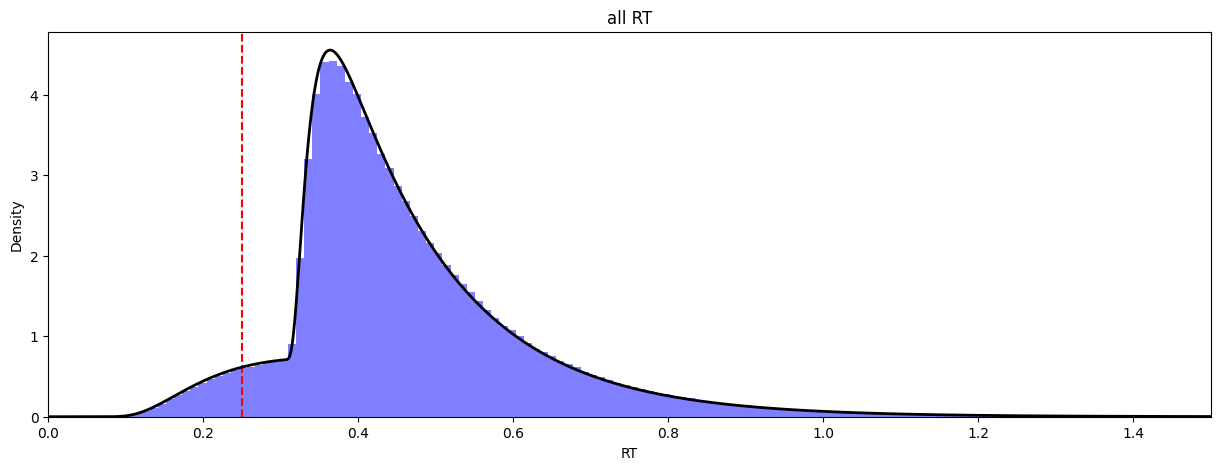

In [13]:
plt.figure(figsize=(15, 5))
plt.hist(all_RT, bins=250, color='b', alpha=0.5, density=True);
plt.axvline(x=t_stim, color='r', linestyle='--')
plt.plot(t_pts, theory, 'k', lw=2);
plt.title('all RT');plt.xlabel('RT');plt.ylabel('Density');
plt.xlim([0, 1.5]);

# up rt

In [14]:
t_pts = np.linspace(0.001, 1.5, 2000)
ABL = ABL_arr[0]; ILD = ILD_arr[0]
up_theory = up_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)

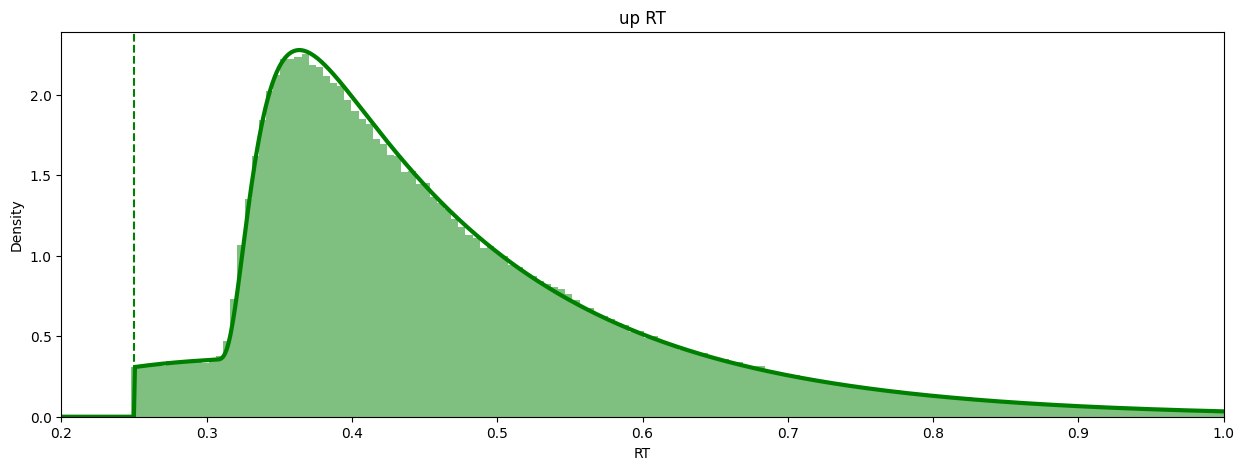

In [15]:
up_rt_idx = np.where(all_choice == 1)[0]
up_rt = all_RT[up_rt_idx]

non_abort_up_rt_idx = np.where(up_rt > t_stim)[0]
up_rt = up_rt[non_abort_up_rt_idx]

up_hist, up_bins = np.histogram(up_rt, bins=500, density=True)  
up_hist *= len(up_rt)/len(all_RT)

plt.figure(figsize=(15, 5))
plt.bar(up_bins[:-1], up_hist, width=up_bins[1]-up_bins[0], color='g', alpha=0.5)
plt.axvline(x=t_stim, color='g', linestyle='--')
plt.plot(t_pts, up_theory, 'g', lw=3);
plt.xlim([0.2, 1]);
plt.xlabel('RT');plt.ylabel('Density');plt.title('up RT');

# down rt

In [16]:
t_pts = np.linspace(0.001, 1.5, 2000)
ABL = ABL_arr[0]; ILD = ILD_arr[0]
down_theory = down_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)

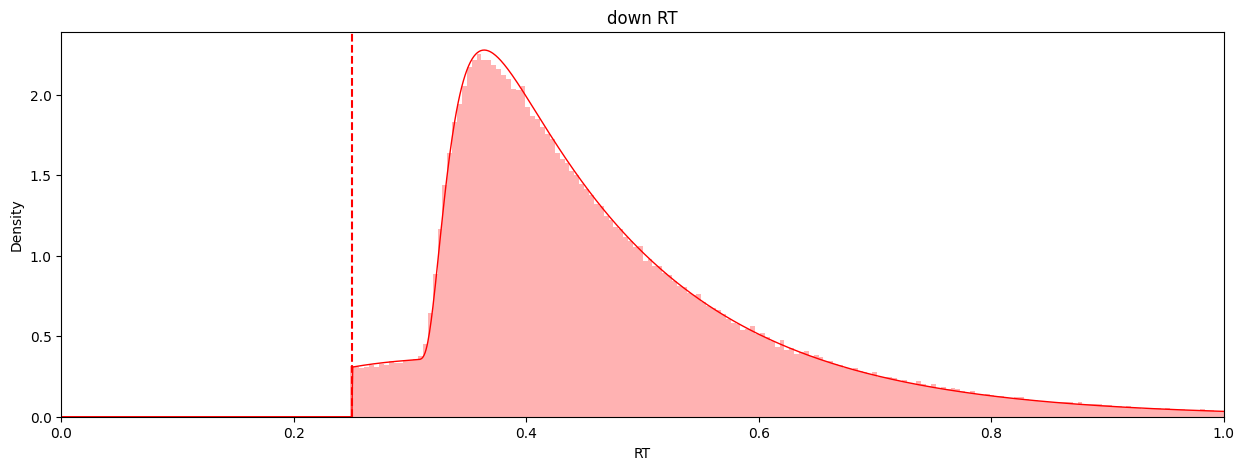

In [17]:
down_rt_idx = np.where(all_choice == -1)[0]
down_rt = all_RT[down_rt_idx]

non_abort_down_rt_idx = np.where(down_rt > t_stim)[0]
down_rt = down_rt[non_abort_down_rt_idx]

down_hist, down_bins = np.histogram(down_rt, bins=500, density=True)
down_hist *= len(down_rt)/len(all_RT)

plt.figure(figsize=(15, 5))
plt.bar(down_bins[:-1], down_hist, width=down_bins[1]-down_bins[0], color='r', alpha=0.3)
plt.axvline(x=t_stim, color='r', linestyle='--')
plt.plot(t_pts, down_theory, 'r', lw=1);
plt.xlim([0, 1]);
plt.xlabel('RT');plt.ylabel('Density');plt.title('down RT');

# debugging 

In [11]:
from scipy.integrate import quad
from psiam_tied_utils import rho_A_t_fn, rho_E_minus_small_t_NORM_fn, P_small_t_btn_x1_x2, cum_A_t_fn, CDF_E_minus_small_t_NORM_fn
K_max = 10
        
P_A = [rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A) for t in t_pts]
P_EA_btn_0_1 = [P_small_t_btn_x1_x2(0, 1, t-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max) for t in t_pts]
P_E_minus_cum = np.zeros(len(t_pts))
for i,t in enumerate(t_pts):
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    if t1 < 0:
        t1 = 0
    P_E_minus_cum[i] = CDF_E_minus_small_t_NORM_fn(t2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, -1, K_max) \
                    - CDF_E_minus_small_t_NORM_fn(t1, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, -1, K_max)


P_E_minus = [rho_E_minus_small_t_NORM_fn(t-t_E_aff-t_stim-t_motor, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, -1, K_max) for t in t_pts]
C_A = [cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A) for t in t_pts]

P_A = np.array(P_A); P_EA_btn_0_1 = np.array(P_EA_btn_0_1); P_E_minus = np.array(P_E_minus); C_A = np.array(C_A)
P_wrong_unnorm = (P_A*(P_EA_btn_0_1+P_E_minus_cum) + P_E_minus*(1-C_A))

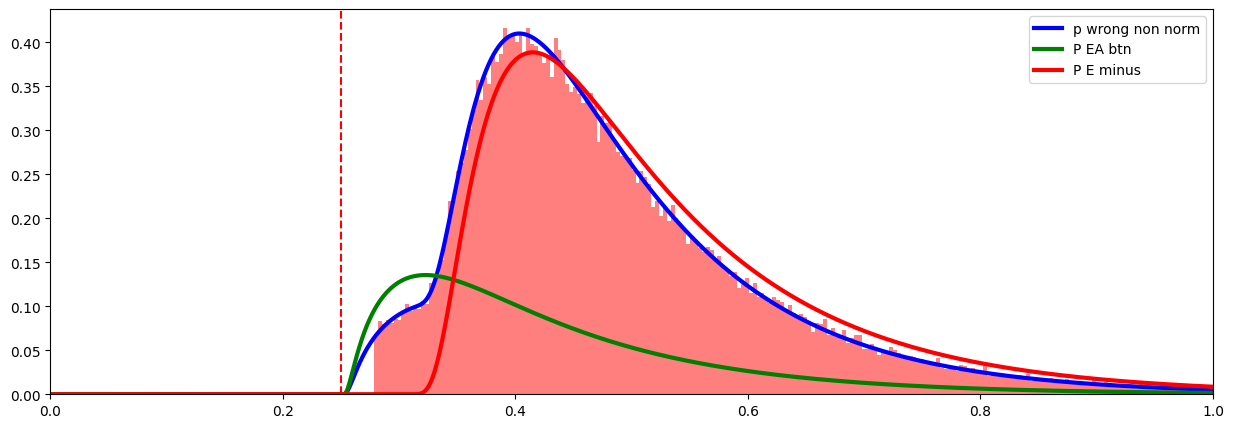

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(t_pts, P_wrong_unnorm, 'b', lw=3, label='p wrong non norm');
plt.axvline(x=t_stim, color='r', linestyle='--');
plt.bar(down_bins[:-1], down_hist, width=down_bins[1]-down_bins[0], color='r', alpha=0.5);
from psiam_tied_utils import P_small_t_btn_x1_x2, rho_E_minus_small_t_NORM_fn

P_EA_btn_0_1 = [P_small_t_btn_x1_x2(0, 1, t-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max) for t in t_pts]

P_E_minus = [rho_E_minus_small_t_NORM_fn(t-t_E_aff-t_stim-t_motor, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, -1, K_max) for t in t_pts]
plt.plot(t_pts, P_EA_btn_0_1, 'g', lw=3, label='P EA btn');
plt.plot(t_pts, P_E_minus, 'r', lw=3, label='P E minus');
plt.legend();
plt.xlim([0, 1]);

# Issue with P EA btn

In [8]:
def simulate_tied_no_norm_2(ILD, ABL, rate_lambda, theta_E, T_0, dt,  T_max, Z_E):
    DV = Z_E; 
    DV_arr = np.full((int(T_max/dt)), np.nan)
    DV_arr[0] = DV

    chi = 17.37; q_e = 1
    theta = theta_E * q_e
    mu = (2*q_e/T_0) * (10**(rate_lambda * ABL/20)) * np.sinh(rate_lambda * ILD/chi)
    sigma = np.sqrt( (2*(q_e**2)/T_0) * (10**(rate_lambda * ABL/20)) * np.cosh(rate_lambda * ILD/ chi) )
    dB = dt**0.5

    # print(f"mu is {mu}, sigma is {sigma}")
    for i in range(1, int(T_max/dt)):
        

        DV += mu*dt + sigma*np.random.normal(0, dB)

        DV_arr[i] = (DV/theta) + 1.0

        if DV >= theta or DV <= -theta:
            DV_arr[i] = np.nan
            return DV_arr



100%|██████████| 499/499 [00:08<00:00, 58.76it/s]


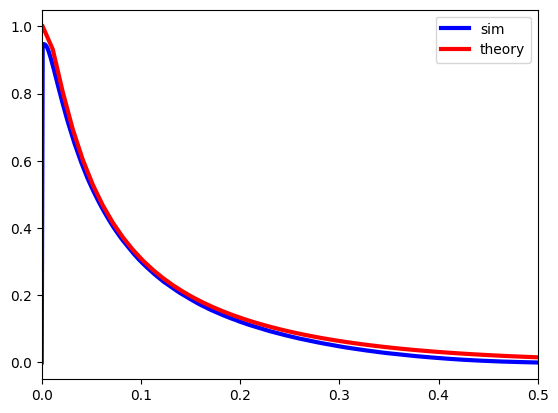

In [32]:
# x1 = 1; x2 = 2
x1 = 0; x2 = 1

from tqdm import tqdm
N_sim = int(1e6)
dt = 1e-3
T_max = 0.5
sim_dv = np.zeros((N_sim, int(T_max/dt)))

starting_pt = -20
for n in tqdm(range(N_sim)):
    sim_dv[n,:] = simulate_tied_no_norm_2(ILD_arr[0], ABL_arr[0], rate_lambda, theta_E, T_0, dt, T_max, starting_pt)


t_pts = np.arange(0, T_max, dt)

btn_x1_x2 = np.zeros_like(t_pts)
for t in tqdm(range(1, len(t_pts))):
    dv = sim_dv[:,t]
    dv = dv[~np.isnan(dv)]

    btn_x1_x2[t] = np.sum((dv >= x1) & (dv <= x2))/N_sim

plt.plot(np.arange(0, T_max, dt), btn_x1_x2, 'b', lw=3, label='sim');
t_pts = np.linspace(0.001, 1, 100)
from psiam_tied_utils import P_small_t_btn_x1_x2
P_EA_btn_0_1_v2 = [P_small_t_btn_x1_x2(x1, x2, t, ABL_arr[0], ILD_arr[0], rate_lambda, T_0, theta_E, starting_pt, K_max) for t in t_pts]
plt.plot(t_pts, P_EA_btn_0_1_v2, 'r', lw=3, label='theory');
plt.legend();
plt.xlim([0, 0.5]);

100%|██████████| 499/499 [00:08<00:00, 61.11it/s] 


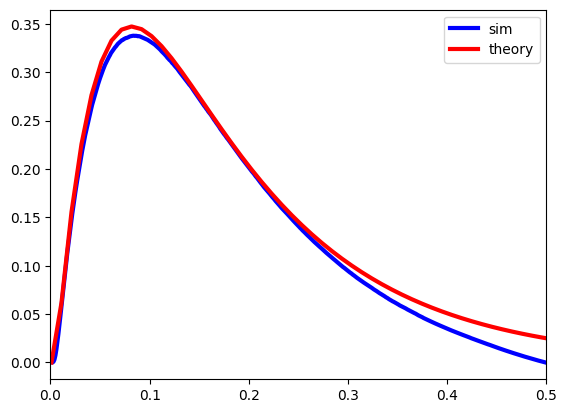

In [20]:
x1 = 1; x2 = 2
# x1 = 0; x2 = 1

from tqdm import tqdm
N_sim = int(1e6)
dt = 1e-3
T_max = 0.5
sim_dv = np.zeros((N_sim, int(T_max/dt)))

starting_pt = -20
for n in tqdm(range(N_sim)):
    sim_dv[n,:] = simulate_tied_no_norm_2(ILD_arr[0], ABL_arr[0], rate_lambda, theta_E, T_0, dt, T_max, starting_pt)


t_pts = np.arange(0, T_max, dt)

btn_x1_x2 = np.zeros_like(t_pts)
for t in tqdm(range(1, len(t_pts))):
    dv = sim_dv[:,t]
    dv = dv[~np.isnan(dv)]

    btn_x1_x2[t] = np.sum((dv >= x1) & (dv <= x2))/N_sim

plt.plot(np.arange(0, T_max, dt), btn_x1_x2, 'b', lw=3, label='sim');
t_pts = np.linspace(0.001, 1, 100)
from psiam_tied_utils import P_small_t_btn_x1_x2
P_EA_btn_0_1_v2 = [P_small_t_btn_x1_x2(x1, x2, t, ABL_arr[0], ILD_arr[0], rate_lambda, T_0, theta_E, starting_pt, K_max) for t in t_pts]
plt.plot(t_pts, P_EA_btn_0_1_v2, 'r', lw=3, label='theory');
plt.legend();
plt.xlim([0, 0.5]);

# check analytic

In [27]:
def P_x_large_t_fn(x, t, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max):
    """
    Prob density that DV at x at time t for large times
    """
    if t <= 0:
        return 0
    
    q_e = 1
    theta = theta_E*q_e

    chi = 17.37
    mu = theta_E * np.tanh(rate_lambda * ILD / chi)
    Z = (Z_E/theta) + 1.0

    
    t_theta = T_0 * (theta_E**2) * (10**(-rate_lambda*ABL/20)) * (1/(2*np.cosh(rate_lambda*ILD/chi)))
    t /= t_theta

    term1 = np.exp(mu*x - mu*Z)
    k_terms = np.arange(1, K_max+1)
    sine_term_1 = np.sin(k_terms * np.pi * Z/2)
    sine_term_2 = np.sin(k_terms * np.pi * x/2)
    exp_term = np.exp(-0.5 * (mu**2 + 0.25*(k_terms**2)*np.pi**2) * t)
    
    sum_term = np.sum(sine_term_1 * sine_term_2 * exp_term)
    return (term1 * sum_term)

def P_x_small_t_fn(x, t, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max):
    """
    Prob density that DV at x at time t for small times
    """
    if t <= 0:
        return 0
    
    q_e = 1
    theta = theta_E*q_e

    chi = 17.37
    mu = theta_E * np.tanh(rate_lambda * ILD / chi)
    Z = (Z_E/theta) + 1.0

    
    t_theta = T_0 * (theta_E**2) * (10**(-rate_lambda*ABL/20)) * (1/(2*np.cosh(rate_lambda*ILD/chi)))
    t /= t_theta

    term1 = 1/(2*np.pi*t)**0.5    
    k_terms = np.linspace(-K_max, K_max, 2*K_max+1)
    exp_1 = np.exp(4*mu*k_terms - (((x - Z - 4*k_terms - mu*t)**2)/(2*t)))
    exp_2 = np.exp(2*mu*(2 - 2*k_terms - Z) - ((x + Z - 4 + 4*k_terms - mu*t)**2)/(2*t))
    exp_diff = exp_1 - exp_2

    return (term1*np.sum(exp_diff))

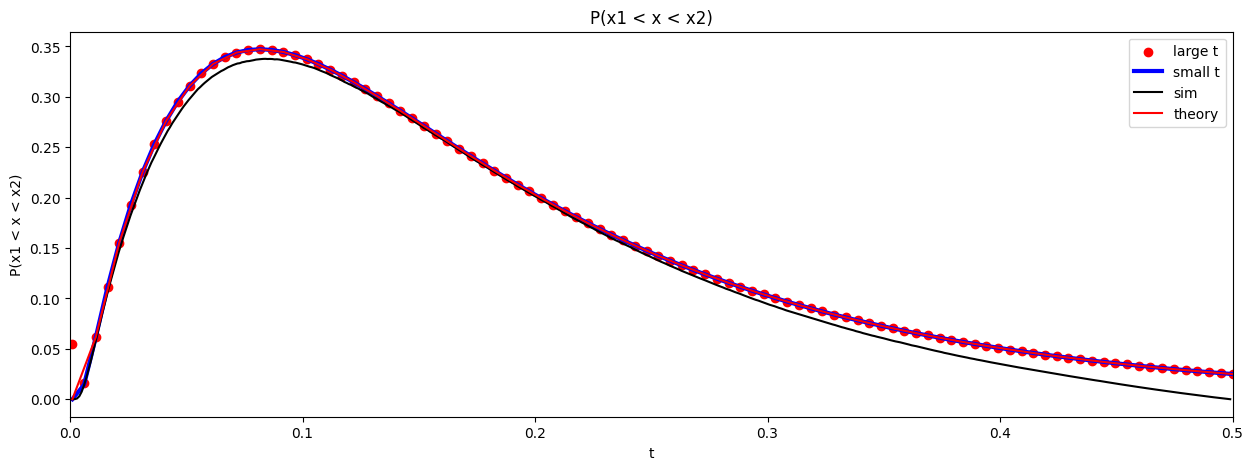

In [30]:
t_pts_num = np.linspace(0.001, 0.5, 100)
from scipy.integrate import quad

x1 = 1; x2 = 2
P_x_large_t = [quad(P_x_large_t_fn, x1, x2, args=(t, ABL_arr[0], ILD_arr[0], rate_lambda, T_0, theta_E, starting_pt, K_max))[0] for t in t_pts_num]
P_x_small_t = [quad(P_x_small_t_fn, x1, x2, args=(t, ABL_arr[0], ILD_arr[0], rate_lambda, T_0, theta_E, starting_pt, K_max))[0] for t in t_pts_num]

plt.figure(figsize=(15, 5))
plt.scatter(t_pts_num, P_x_large_t, color='r', label='large t');
plt.plot(t_pts_num, P_x_small_t, 'b', lw=3, label='small t');
plt.plot(np.arange(0, T_max, dt), btn_x1_x2, 'k', label='sim');
plt.plot(t_pts, P_EA_btn_0_1_v2, 'r', label='theory');

plt.legend();
plt.xlabel('t');plt.ylabel('P(x1 < x < x2)');plt.title('P(x1 < x < x2)');
plt.xlim([0, 0.5]);

In [ ]:
t_pts_num = np.linspace(0.001, 0.5, 100)
from scipy.integrate import quad

x1 = 0; x2 = 1
P_x_large_t = [quad(P_x_large_t_fn, x1, x2, args=(t, ABL_arr[0], ILD_arr[0], rate_lambda, T_0, theta_E, starting_pt, K_max))[0] for t in t_pts_num]
P_x_small_t = [quad(P_x_small_t_fn, x1, x2, args=(t, ABL_arr[0], ILD_arr[0], rate_lambda, T_0, theta_E, starting_pt, K_max))[0] for t in t_pts_num]

plt.figure(figsize=(15, 5))
plt.scatter(t_pts_num, P_x_large_t, color='r', label='large t');
plt.plot(t_pts_num, P_x_small_t, 'b', lw=3, label='small t');
plt.plot(np.arange(0, T_max, dt), btn_x1_x2, 'k', label='sim');
plt.plot(t_pts, P_EA_btn_0_1_v2, 'r', label='theory');

plt.legend();
plt.xlabel('t');plt.ylabel('P(x1 < x < x2)');plt.title('P(x1 < x < x2)');
plt.xlim([0, 0.5]);